In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os

In [61]:
file_path = os.path.join('..', 'aggregated_data.csv')
data = pd.read_csv(file_path)

# inflation adjustment
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop( # drop columns not used for training
    ['avg_price_steers_ML1', 
     'avg_price_steers_ML1_2', 
     'avg_price_heifers_ML1', 
     'avg_price_heifers_ML1_2', 
     'NATIONAL_AUCTION_SALES', 
     'NATIONAL_TOTAL_SALES', 
     'TEXAS_AUCTION_SALES', 
     'CORN_FUTURES_TYPICAL_PRICE', 
     'DIESEL_RETAIL_PRICE', 
     'ALFAFA_HAY_PPI', 
     'CORN_PPI',
    #  'US_MXN_RATES',
     ], axis=1)


In [62]:
X = data.drop(['AVG_PRICE_AUCTION'], axis=1)
y = data['AVG_PRICE_AUCTION']

# # SPLIT DATA INTO 80/20 TRAINING TESTING SETS
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_size = int(len(data.index) * 0.9)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]


X_train = train_data.drop('AVG_PRICE_AUCTION', axis=1)
y_train = train_data['AVG_PRICE_AUCTION']
X_test = test_data.drop('AVG_PRICE_AUCTION', axis=1)
y_test = test_data['AVG_PRICE_AUCTION']

In [63]:
def print_metrics(X_test, y_test, y_pred): # Helper function to print model metrics
    r2 = r2_score(y_test, y_pred) # R²
    # print(f'R² Score: {r2}')

    # n = X_test.shape[0]
    # k = X_test.shape[1]
    # adj_r2 = 1-((1-rf_r2)*(n-1)/(n-k-1)) # Adjusted-R²
    # print(f'Adjusted-R² Score: {adj_r2}')

    prcorr = np.corrcoef(y_test, y_pred)[0,1] # Pearson Correlation Coefficient 
    # print("Pearson correlation:", prcorr)

    srcorr, p_value = spearmanr(y_test, y_pred) # Spearman’s Rank Correlation
    # print("Spearman correlation:", srcorr)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
    # print(f'Root Mean Squared Error (RMSE): {rmse}')

    mae = mean_absolute_error(y_test, y_pred) # MAE
    # print(f'Mean Absolute Error (MAE): {mae}')

    return (r2, prcorr, srcorr, rmse, mae)

In [64]:
# CREATE AND TRAIN LINEAR REGRESSION MODEL
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lrg_train_pred = lin_reg.predict(X_train)
lrg_forecast_pred = lin_reg.predict(X_test)
residuals = y_test-lrg_forecast_pred
# EVALUATING MODEL PERFORMANCE
print_metrics(X_test, y_test, lrg_forecast_pred)

(-0.36131727261510904,
 np.float64(0.7461542367266165),
 np.float64(0.7124229492650545),
 np.float64(16.70398170458198),
 13.404385523445143)

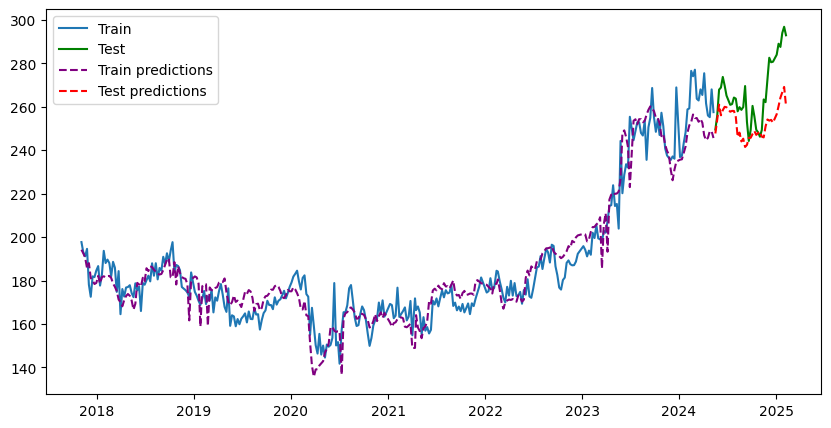

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test', color='green')
plt.plot(y_train.index, lrg_train_pred, label='Train predictions', color='purple', linestyle='--')
plt.plot(y_test.index, lrg_forecast_pred, label='Test predictions', color='red', linestyle='--')
plt.legend()
plt.savefig(os.path.join('..', 'figures', 'linear_regression_plot.png'), dpi=300)
plt.show()